In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing


### Load Dataset

In [18]:
df = pd.read_csv('data/ex.csv')

dataset_preview = df.copy()
# print(dataset_preview.tail())

dataset = df.copy()

In [19]:
def plot_dataset(dataset):
    for index, point in enumerate(dataset):
        plt.scatter(point[0], point[1], color="blue")
    plt.show()

# plot_dataset(dataset.copy().values)

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of our models.

In [20]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


### Split features from labels
Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [21]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('y')
test_labels = test_features.pop('y')

### Normalization

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer

The preprocessing.Normalization layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:


In [22]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


[0.01996622]
First example: [[0.06]]

Normalized: [[0.04]]


### Linear regression

Before building a DNN model, start with a linear regression.
One Variable

Start with a single-variable linear regression, to predict `y` from `x`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

- Normalize the input `x`.
- Apply a linear transformation $(y = mx+b)$ to produce 1 output using `layers.Dense`.

The number of inputs can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [23]:
x = np.array(train_features['x'])
x_normalizer = preprocessing.Normalization(input_shape=[1,])
x_normalizer.adapt(x)


Build the sequential model

In [24]:
x_model = tf.keras.Sequential([
    x_normalizer,
    layers.Dense(1)
])

# x_model.summary()


This model will predict `y` from `x`.

Run the untrained model on the first 10 `x` values. The output won't be good, but you'll see that it has the expected shape, (10,1):




In [25]:
x_model.predict(x[:10])
print(x[:10])
print(x_model.predict(x[:10]))


[ 0.05866233 -2.82062109 -0.74967405  0.20560761  0.2634511   0.85870597
  0.60995751 -0.77530134  0.94399413  0.46771278]
[[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]]


Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [26]:
x_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')


Once the training is configured, use `Model.fit()` to execute the training:

In [27]:
%%time
history = x_model.fit(
    train_features['x'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


Wall time: 5.95 s


Visualize the model's training progress using the stats stored in the history object.

In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,NaN,NaN,95
96,NaN,NaN,96
97,NaN,NaN,97
98,NaN,NaN,98
99,NaN,NaN,99


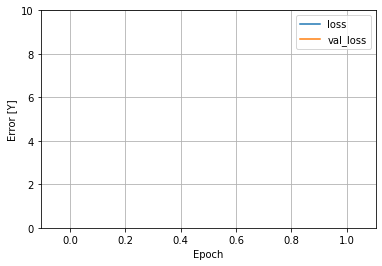

In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Y]')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Collect the results on the test set, for later:

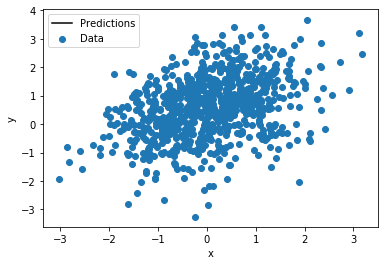

In [30]:
test_results = {}

test_results['x_model'] = x_model.evaluate(
    test_features['x'],
    test_labels, verbose=0)

x = tf.linspace(0.0, -3, 8)
y = x_model.predict(x)

def plot_x_model(x, y):
  plt.scatter(train_features['x'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()

plot_x_model(x,y)


